<a href="https://colab.research.google.com/github/Priyanshu0651/DeepIntoCNNs/blob/main/Hack2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 62 bytes


In [2]:
!kaggle datasets download -d gpiosenka/100-bird-species

 99% 1.80G/1.81G [00:16<00:00, 68.4MB/s]
100% 1.81G/1.81G [00:16<00:00, 117MB/s] 


In [3]:
!pip install jcopdl


  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=bb3958659f88bf00d80ae49b7ad7f695995210a2e655170aecb54e608ba83d94
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [4]:
!unzip 100-bird-species.zip

Streaming output truncated to the last 5000 lines.
  inflating: birds_rev2/train/BOBOLINK/125.jpg  
  inflating: birds_rev2/train/BOBOLINK/126.jpg  
  inflating: birds_rev2/train/BOBOLINK/127.jpg  
  inflating: birds_rev2/train/BOBOLINK/128.jpg  
  inflating: birds_rev2/train/BOBOLINK/129.jpg  
  inflating: birds_rev2/train/BOBOLINK/130.jpg  
  inflating: birds_rev2/train/BOBOLINK/131.jpg  
  inflating: birds_rev2/train/BOBOLINK/132.jpg  
  inflating: birds_rev2/train/BOBOLINK/133.jpg  
  inflating: birds_rev2/train/BOBOLINK/134.jpg  
  inflating: birds_rev2/train/BOBOLINK/135.jpg  
  inflating: birds_rev2/train/BOBOLINK/136.jpg  
  inflating: birds_rev2/train/BOBOLINK/137.jpg  
  inflating: birds_rev2/train/BOBOLINK/138.jpg  
  inflating: birds_rev2/train/BOBOLINK/139.jpg  
  inflating: birds_rev2/train/BOBOLINK/140.jpg  
  inflating: birds_rev2/train/BOBOLINK/141.jpg  
  inflating: birds_rev2/train/BOBOLINK/142.jpg  
  inflating: birds_rev2/train/BOBOLINK/143.jpg  
  inflating: birds

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

##### Loading Data

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pylab import *

import torch
from torchvision import datasets, transforms

import os

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
device

device(type='cuda', index=0)

In [9]:
PATH ="/content/birds" 

In [10]:
data_dir = PATH

train_transforms = transforms.Compose([transforms.ToTensor()])
                                      

valid_transforms = transforms.Compose([transforms.ToTensor()])
                                     

test_transforms = transforms.Compose([transforms.ToTensor()])
                                     


train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data,batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Making a model from scratch
* GoogLeNet/InceptionNet

##### Important features which need to be kept at back of the mind while implementing it are shown below:

These are 2 versions of inception net but number of parameters to train will be very large on training part a so part b is implemented 

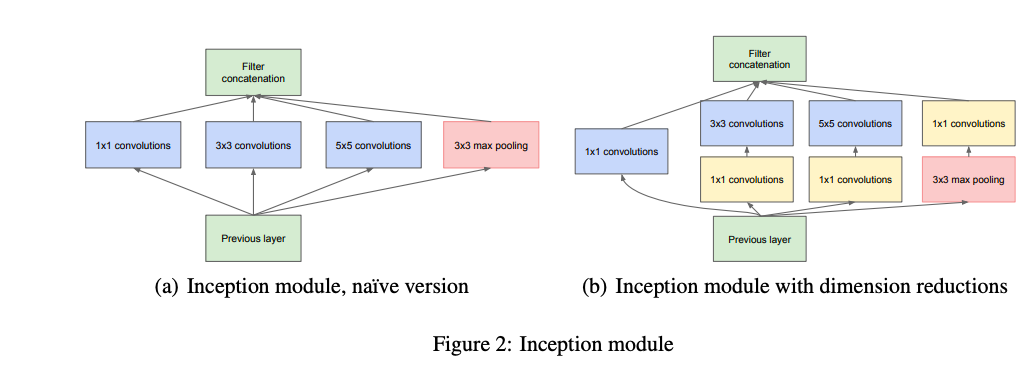

Padding need to found manually. Complete Architecture of Part b module(the one with dimensionality reduction) is shown below

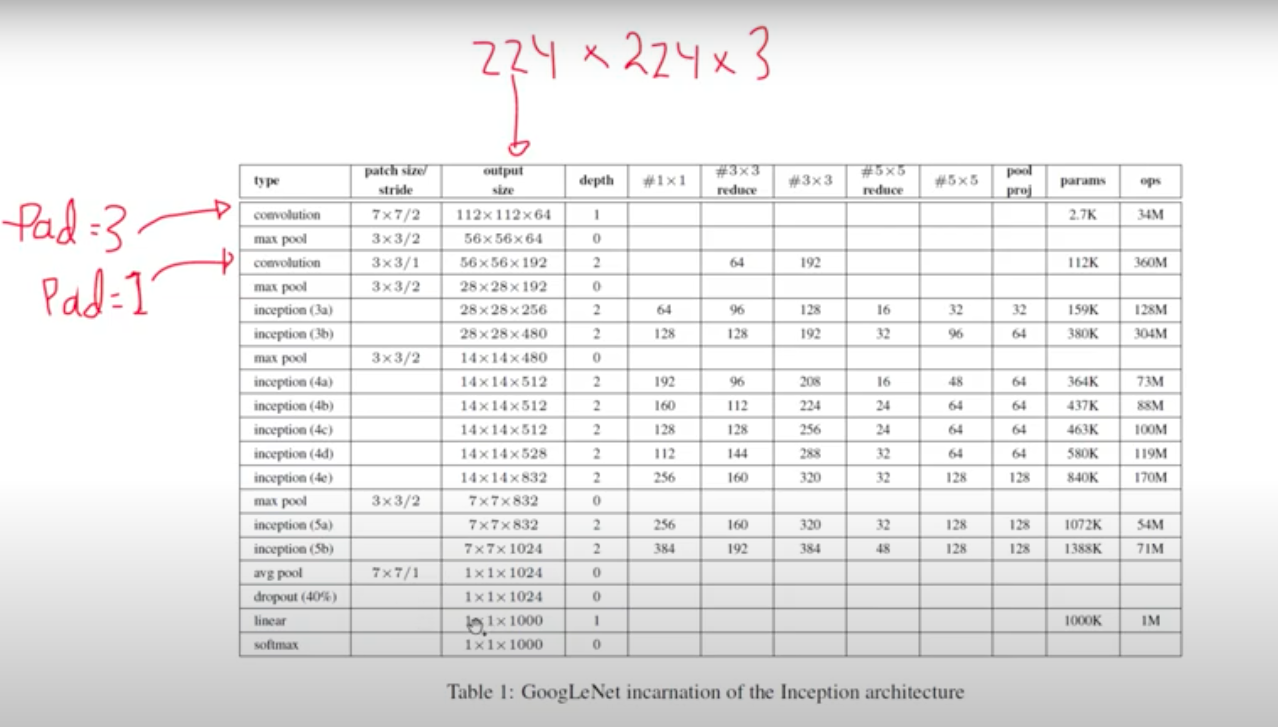

Auxiliary Softmax to avoid Model overfitting and make sure that initial layers kaam ke hai

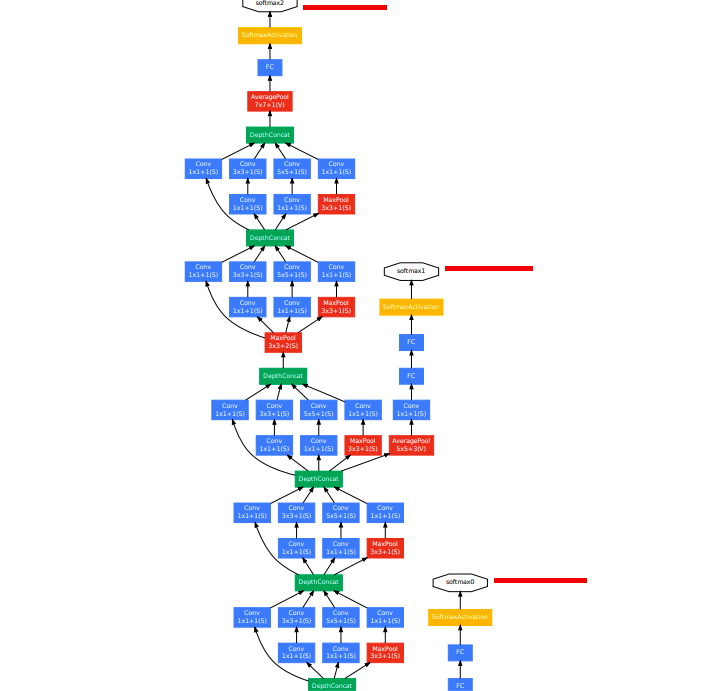

##### Implementation Part

In [11]:
import torch
import torch.nn as  nn
import torch.nn.functional as F

In [12]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [13]:
class Inception_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Inception_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
            conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
            conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
        )

    def forward(self, x):
        return torch.cat(
            [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
        )


In [14]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=275):
        super(GoogLeNet, self).__init__()
        

        self.conv1 = conv_block(
            in_channels=3,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
        )

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)

        

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)

       

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        
        return x


In [15]:
from torch import optim

In [16]:
model = GoogLeNet(num_classes=275).to('cuda')

In [17]:
pytorch_total_params = np.sum(p.numel() for p in model.parameters())
pytorch_total_params

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """Entry point for launching an IPython kernel.


6265699

In [20]:
batch_size = 128
crop_size = 224

In [21]:
config = set_config({
    'batch_size': batch_size,
    'crop_size': crop_size,
    'output_size': len(train_data.classes)
})

In [22]:
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

In [23]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = -116.2125 | Test_cost  = -347.2023 | Train_score = 0.0000 | Test_score = 0.0036 |




Epoch     2
Train_cost  = -505.7379 | Test_cost  = -914.3608 | Train_score = 0.0000 | Test_score = 0.0029 |
==> EarlyStop patience =  1 | Best test_score: 0.0036




Epoch     3
Train_cost  = -1150.5477 | Test_cost  = -1696.7717 | Train_score = 0.0000 | Test_score = 0.0036 |
==> EarlyStop patience =  2 | Best test_score: 0.0036
==> Execute Early Stopping at epoch: 3 | Best test_score: 0.0036
==> Best model is saved at model


/usr/local/lib/python3.7/dist-packages/ipykernel/pylab/backend_inline.py:179: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


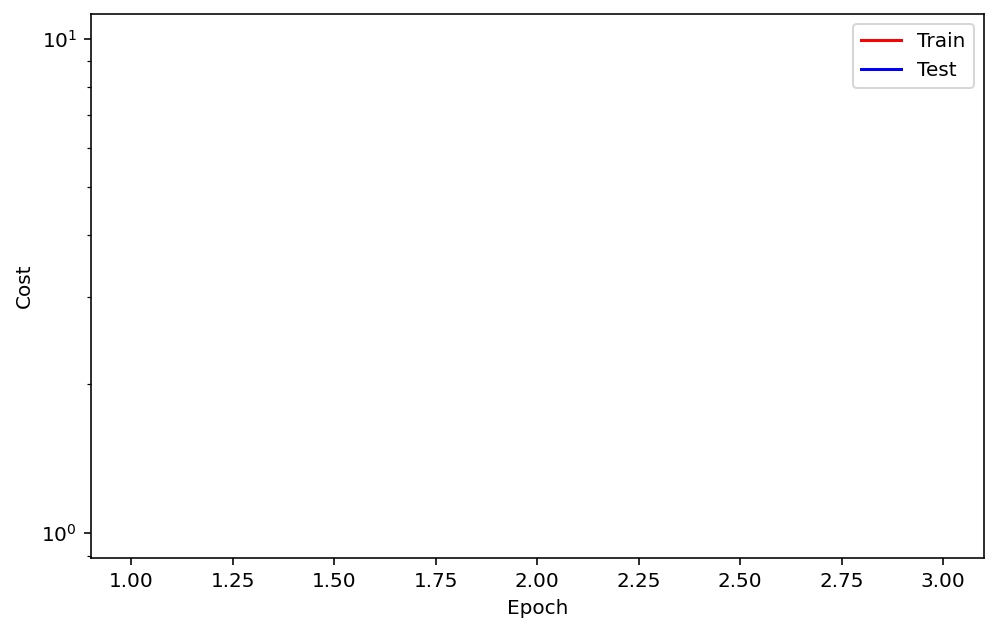

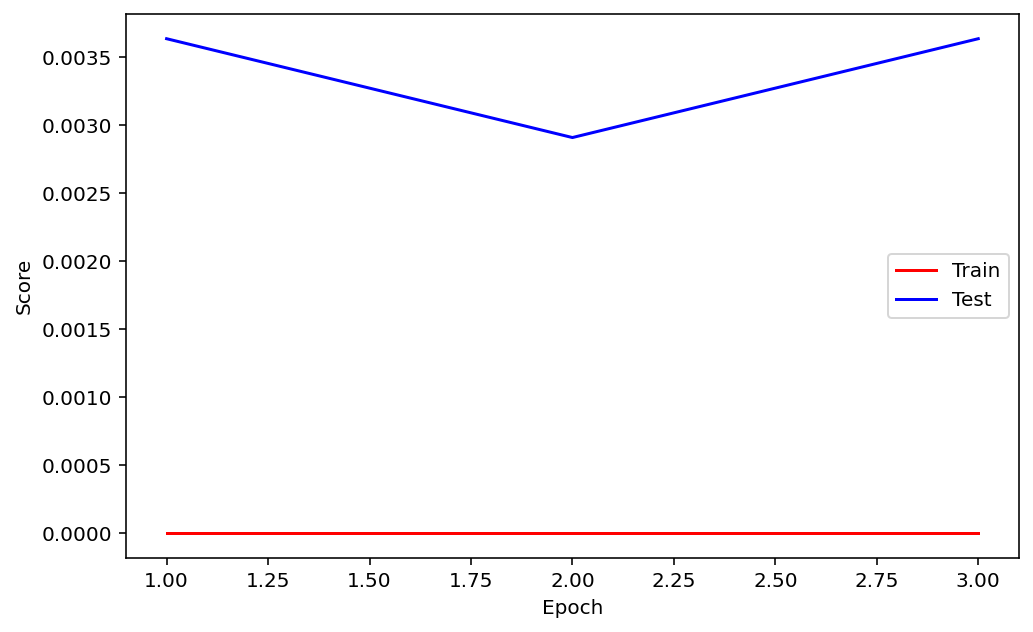

In [25]:
while True:
  train_cost, train_score = loop_fn('train', train_data, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', valid_data, validloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break